In [6]:
from LensCalcPy.survey import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
from tqdm import tqdm
from pathos.multiprocessing import ProcessingPool as Pool
import functools

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# HSC Params
# l = 121.2
# b = -21.6
# ds = 770
# obsTime = 7
# survey_area = 0
# n_sources = 8.7e7
# efficiency = 0.5
from LensCalcPy.parameters import *

In [8]:
s = Survey(l, b, ds, obsTime, survey_area=survey_area, n_sources=n_sources)
s

Survey(l=121.2, b=-21.6, source_dist=770, obs_time=7, survey_area=0)

In [9]:
t_es = np.logspace(-2, 3, 20) #hours

In [10]:
m = 1e-7
alpha = 2
# s.add_pbh(m)
s.add_ffp(mlow=m, alpha=alpha)
diff_rates = s.get_crossing_times_rates_ffp(t_es, finite=False)

In [11]:
diff_rates_finite = s.get_crossing_times_rates_ffp(t_es, finite=True)

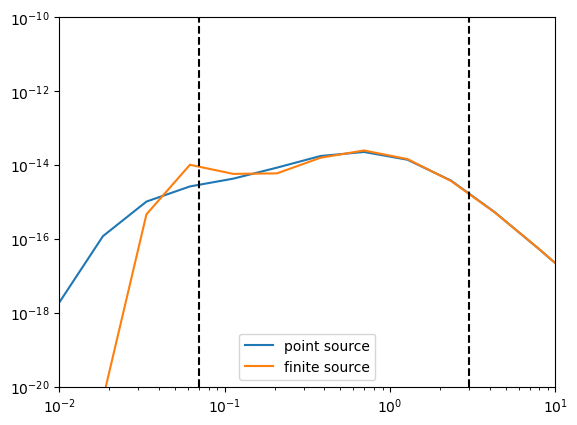

In [64]:
plt.loglog(t_es, diff_rates, label='point source')
plt.loglog(t_es, diff_rates_finite, label='finite source')
plt.axvline(0.07, color='k', ls='--')
plt.axvline(3, color='k', ls='--')
plt.xlim(1e-2, 1e1)
plt.ylim(1e-20,1e-10)
plt.legend()
plt.show()

In [13]:
diff_rate_interp = interp1d(t_es, diff_rates)

In [14]:
ti = 0.07
tf = 3
dnds = quad(diff_rate_interp, ti, tf)[0]

In [15]:
s.n_sources*efficiency*dnds

1.4468149794933735e-06

In [16]:
def get_n_events(m, alpha=2, finite=False):
    s.add_ffp(m, alpha=alpha)
    diff_rates = s.get_crossing_times_rates_ffp(t_es, finite=finite)
    rate_interp = interp1d(t_es, diff_rates)
    dnds = quad(rate_interp, ti, tf)[0]
    return s.n_sources*efficiency*dnds*obsTime

def get_n_events_parallel(m_pbhs, alpha=2, finite=False):
    with Pool() as p:
        f = functools.partial(get_n_events, alpha=alpha, finite=finite)
        results = list(tqdm(p.imap(f, m_pbhs), total=len(m_pbhs)))
    return results

def get_constraint_fdm(m, finite=False):
    n_events = get_n_events(m, finite=finite)
    if n_events != 0:
        return 4.74/n_events
    else:
        return 1
    
def get_constraint_fdm_parallel(m_pbhs, finite=False):
    with Pool() as p:
        f = functools.partial(get_constraint_fdm, finite=finite)
        results = list(tqdm(p.imap(f, m_pbhs), total=len(m_pbhs)))

    return results

In [17]:
mlow_ffps = np.logspace(-15, -5, 10)
n_events_arr = get_n_events_parallel(mlow_ffps, alpha=alpha, finite=False)

100%|██████████| 10/10 [00:30<00:00,  3.04s/it]


In [18]:
n_events_arr_finite = get_n_events_parallel(mlow_ffps, alpha=alpha, finite=True)

100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


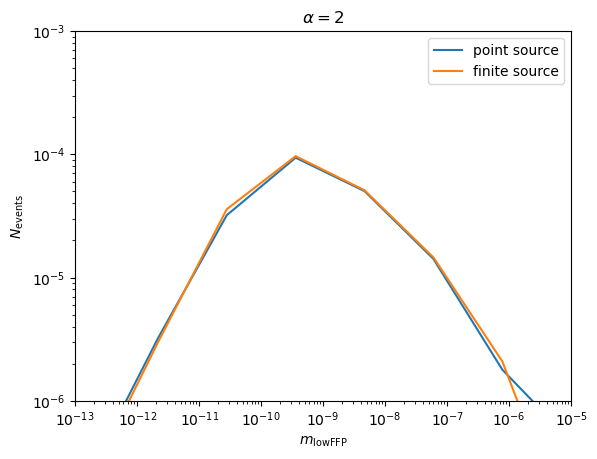

In [19]:
plt.loglog(mlow_ffps, n_events_arr, label='point source')
plt.loglog(mlow_ffps, n_events_arr_finite, label='finite source')
plt.xlabel(r'$m_{\rm low FFP}$')
plt.ylabel(r'$N_{\rm events}$')
plt.title(r'$\alpha = {}$'.format(alpha))
plt.xlim(1e-13, 1e-5)
plt.ylim(1e-6, 1e-3)
plt.legend()
plt.show()